# Codes for the analysis of the progressive orders of the single-file movements

- Written by Hiroki Koda at Primate Reseach Institute, Kyoto University
- 2021-11-04

## 1. Preparation

### 1.1. Module imports

In [1]:
# read the modules to be used in the progressive order analysis.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
import networkx as nx
import community
import itertools
import sys
import os
import seaborn as sns
from graphviz import Digraph
import itertools
import random

### 1.2. Directory set of the original data file
This depends on the locations of the file directories for own local system. We did not upload the original file here.

In [2]:
data_file_directory = "../../toyoda_caravan_observation/"

### 1.3. Data preprocessing from the observational raw data to the analyzable order data
- read the original single-file movement data of the fourth group in 2019-2020. 
- `df_cameratrap_all` is the single-filemovement data
- `mother_list` is the pandas dataframe of the female lists of the infant-carrying or non-infant carrying females.

In [3]:
df_cameratrap_all = pd.read_excel("{0}progression_order_analysis_marctoides.xlsx".format(data_file_directory))
mother_list = pd.read_excel("{0}progression_order_analysis_marctoides.xlsx".format(data_file_directory), sheet_name = "motherlist")

# omit the 4 subjects, ajiantam, azeno, ekumea and tukamoto because the observations of the 4 monkeys were less than 2.
df_cameratrap = df_cameratrap_all.query("name != 'ajiantam' and name != 'azeno' and name != 'ekumea' and name != 'tukamoto'")

# and, omit the subadult, infant or unkown age classes from the original data (only adult data)
df_cameratrap = df_cameratrap[df_cameratrap.age == 'adult']

# arys were generated
# ary_subject_name: subject name
# ary_subject_id; numerical id of the subject name list
ary_subject_name = df_cameratrap.name.unique()
ary_subject_id = [i for i,sub in enumerate(ary_subject_name)]

# subject name dictionary of the {"name": id} was generated.
dict_sub_id = {"unknown":0}
for i, sub in enumerate(ary_subject_name[ary_subject_name != 'unknown']):
    dict_sub_id_temp = {sub:i+1}
    dict_sub_id = {**dict_sub_id,**dict_sub_id_temp}
 

# map the numerical id to name labels in the datafram of the cameratrap data.
df_cameratrap['name_id'] = df_cameratrap['name'].map(dict_sub_id)

# read the data of the copulation counts
df_copulation = pd.read_excel("{}4th_male_copulation_data.xlsx".format(data_file_directory), sheet_name=0)

name_list = df_cameratrap[df_cameratrap['name'] != "unknown"].name.unique()
subject_sex_dict = {name_list[i]: df_cameratrap.query("name == '%s'" %name_list[i]).sex.unique()[0] for i in range(len(name_list))}
male_list = [k for k, v in subject_sex_dict.items() if v == 'male']

female_list = [k for k, v in subject_sex_dict.items() if v == 'female']
mother_female_list = [sub for sub in female_list if sub in mother_list[mother_list.with_infant == 1].name.unique()]
nonmother_female_list = [sub for sub in female_list if sub in mother_list[mother_list.with_infant == 0].name.unique()]

## 2. Progression order of all monkeys, including all unidentifed but comfirmed age-class categories

### 2.1. Visualize the single-file movements, including all subjects, i.e., young adult, infant, or unidentified subjects.

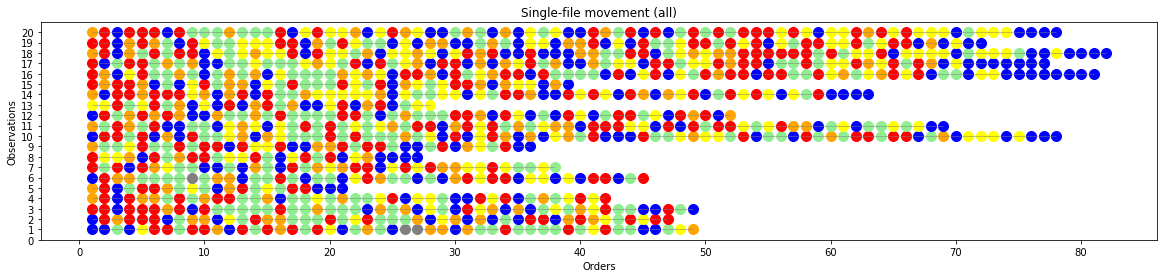

In [4]:
df_cameratrap_all["age"] = df_cameratrap_all["age"].fillna('unidentified')
df_cameratrap_all["sex"] = df_cameratrap_all["sex"].fillna('unidentified')
df_cameratrap_all["age_sex_category"] = df_cameratrap_all["age"] + df_cameratrap_all["sex"]
df_cameratrap_all.age_sex_category = df_cameratrap_all.age_sex_category.fillna('unidentified')

infant_carry_status_mapping = {v:"with_infant" for v in mother_female_list}
immigrant_male_status_mapping = {v: "immigrantmale" for v in ["tsukamoto", "morikami", "kuroda", "higuchi", "nakahara"]}

df_cameratrap_all["infant_carry_status"] = df_cameratrap_all.name.map(infant_carry_status_mapping).fillna('wo_infant')
df_cameratrap_all["immigrant_male_status"] = df_cameratrap_all.name.map(immigrant_male_status_mapping).fillna('')
df_cameratrap_all["age_sex_category"] = df_cameratrap_all["age"] + df_cameratrap_all["sex"] + df_cameratrap_all["infant_carry_status"] + df_cameratrap_all["immigrant_male_status"]
df_cameratrap_all.age_sex_category = df_cameratrap_all.age_sex_category.fillna('unidentified')

df_cameratrap_all.age_sex_category.unique()

age_sex_category_color_mapping_all = {
    "adultmalewo_infant": "blue",
    "adultmalewo_infantimmigrantmale": "blue",
    "adultfemalewo_infant": "red",
    "adultfemalewith_infant": "orange",
    "subadultmalewo_infant": "lightgreen",
    "subadultunidentifiedwo_infant": "lightgreen",
    "subadultfemalewo_infant":"lightgreen",
    "infantmalewo_infant": "yellow",
    "infantunidentifiedwo_infant":"yellow",
    "adultunidentifiedwo_infant": "grey",
    "unidentifiedunidentifiedwo_infant": "grey",
}

fig, ax = plt.subplots(1,1, figsize = (20,4))

for unit_id in df_cameratrap_all['unit'].unique():
    caravan_agesex = df_cameratrap_all[df_cameratrap_all['unit'] == unit_id].reset_index().age_sex_category.map(age_sex_category_color_mapping_all)
    # caravan = df_cameratrap[df_cameratrap['unit'] == unit_id].reset_index().name
    plt.hlines(y = unit_id,xmin = 1, xmax = len(caravan_agesex),colors="grey", linewidth = 0.5)
    for j, sub in enumerate(caravan_agesex):
        col = sub
        ax.scatter(j+1,unit_id, color = col, s=100)
            
ax.set_yticks(range(21))
plt.title('Single-file movement (all)')
plt.xlabel('Orders')
plt.ylabel('Observations')
plt.savefig('png/figure_1_single_file_movements_all_age_sex.png', dpi = 300)
plt.savefig('eps/figure_1_single_file_movements_all_age_sex.eps')

### 2.2. Generate randam permutation baseline values for the transition diagram of the single-file movements including all subjects (inc. infants or any monkeys).

In [5]:
iter_n = 10000

# init the transition counter
# note: make adjacency zero matrix here; row index corresponds to ["start", "blue", "red", "orange", "green", "yellow","end"]. 
# Accordingly, the index is set as, start: 0, blue: 1, red: 2, orange: 3, green: 4, yellow: 5, end: 6
transition_counter_random = np.zeros(shape = (7,7,iter_n))
dict_color2index = {
    "start": 0, 
    "blue": 1, 
    "red": 2, 
    "orange": 3, 
    "green": 4, 
    "yellow": 5, 
    "end": 6,
    "grey": 7,
}

# mapping disctionary is set here.
age_sex_category_color_mapping_all = {
    "adultmalewo_infant": "blue",
    "adultmalewo_infantimmigrantmale": "blue",
    "adultfemalewo_infant": "red",
    "adultfemalewith_infant": "orange",
    "subadultmalewo_infant": "green",
    "subadultunidentifiedwo_infant": "green",
    "subadultfemalewo_infant":"green",
    "infantmalewo_infant": "yellow",
    "infantunidentifiedwo_infant":"yellow",
    "adultunidentifiedwo_infant": "grey",
    "unidentifiedunidentifiedwo_infant": "grey",
}
for n in range(iter_n):
    for i in df_cameratrap.unit.unique():
        caravan = list(df_cameratrap_all[df_cameratrap_all['unit'] == i].reset_index().age_sex_category.map(age_sex_category_color_mapping_all))
        random.shuffle(caravan)
        for j in range(1,len(caravan)):
            pre_monkey = dict_color2index[caravan[j-1]]
            post_monkey = dict_color2index[caravan[j]]

            if (pre_monkey == 7 or post_monkey == 7):
                pass
            else:
                transition_counter_random[pre_monkey,post_monkey,n] += 1 
        if caravan[0] != "grey":
            transition_counter_random[0,dict_color2index[caravan[0]],n] += 1
        if caravan[-1] != "grey":
            transition_counter_random[dict_color2index[caravan[-1]],-1,n] += 1

transition_counter_probablity_random_baseline = np.zeros(shape = (7,7,iter_n))
transition_counter_probablity_random_baseline[1:-1,1:-1,:] = transition_counter_random[1:-1,1:-1,:]/np.sum(transition_counter_random[1:-1,1:-1,0])
transition_counter_probablity_random_baseline[0,:,:] = transition_counter_random[0,:,:]/np.sum(transition_counter_random[0,:,0])
transition_counter_probablity_random_baseline[:,-1,:] = transition_counter_random[:,-1,:]/np.sum(transition_counter_random[:,-1,0])

### 2.3. Generate transition diagram of the single-file movements including all subjects. The comparision value data was generated above code, section 2.2.

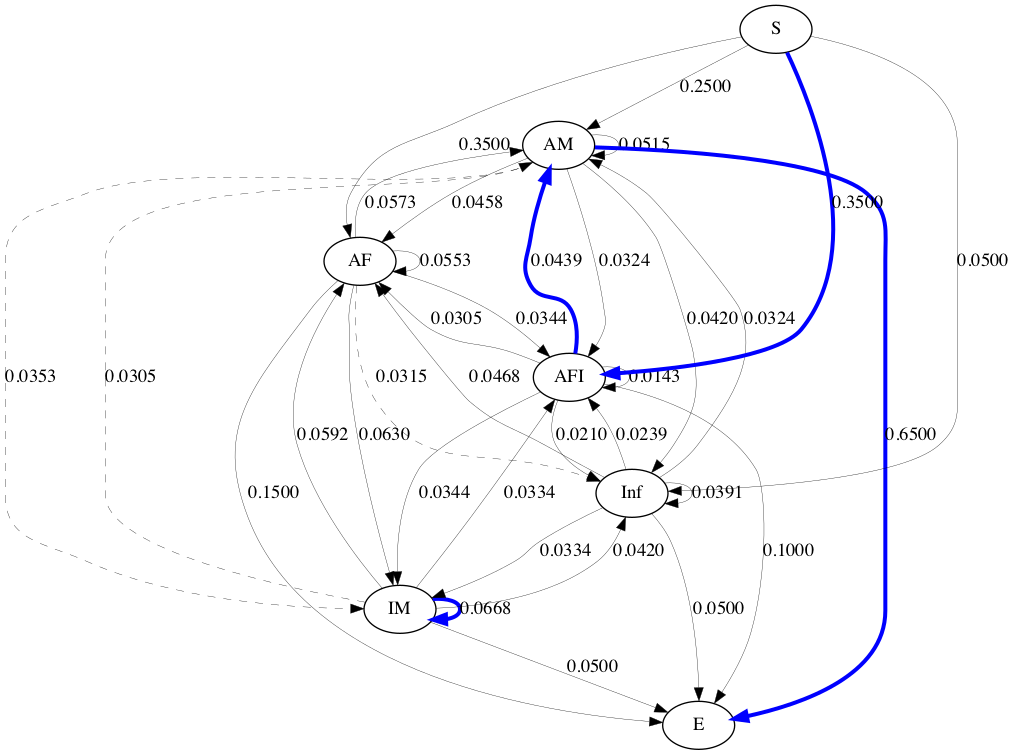

In [7]:
# init the transition counter
# note: make adjacency zero matrix here; row index corresponds to ["start", "blue", "red", "orange", "green", "yellow","end"]. 
# Accordingly, the index is set as, start: 0, blue: 1, red: 2, orange: 3, green: 4, yellow: 5, end: 6
transition_counter = np.zeros(shape = (7,7))
dict_color2index = {
    "start": 0, 
    "blue": 1, 
    "red": 2, 
    "orange": 3, 
    "green": 4, 
    "yellow": 5, 
    "end": 6,
    "grey": 7,
}

# mapping disctionary is set here.
age_sex_category_color_mapping_all = {
    "adultmalewo_infant": "blue",
    "adultmalewo_infantimmigrantmale": "blue",
    "adultfemalewo_infant": "red",
    "adultfemalewith_infant": "orange",
    "subadultmalewo_infant": "green",
    "subadultunidentifiedwo_infant": "green",
    "subadultfemalewo_infant":"green",
    "infantmalewo_infant": "yellow",
    "infantunidentifiedwo_infant":"yellow",
    "adultunidentifiedwo_infant": "grey",
    "unidentifiedunidentifiedwo_infant": "grey",
}

for i in df_cameratrap.unit.unique():
    caravan = list(df_cameratrap_all[df_cameratrap_all['unit'] == i].reset_index().age_sex_category.map(age_sex_category_color_mapping_all))
    # print(caravan)
    for j in range(1,len(caravan)):
        pre_monkey = dict_color2index[caravan[j-1]]
        post_monkey = dict_color2index[caravan[j]]
        
        if (pre_monkey == 7 or post_monkey == 7):
            pass
        else:
            transition_counter[pre_monkey,post_monkey] += 1 
        
    transition_counter[0,dict_color2index[caravan[0]]] += 1
    transition_counter[dict_color2index[caravan[-1]],-1] += 1

g = Digraph(format="png")

g.node("1", label="AM")
g.node("2", label="AF")
g.node("3", label="AFI")
g.node("4", label="IM")
g.node("5", label="Inf")
g.node("0",label="S")
g.node("6", label="E")


for i, j in list(itertools.product(range(7), range(7))):
    edge_style = "solid"
    color = "black"
    penwidth = "0.25"

    if i == 0 and j == 6:
        pass
    elif i == 6 or j == 0:
        pass
    elif transition_counter[i,j] == 0:
        pass
    elif i == 0 or j == 6:
        if transition_counter[i,j]/20 < np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 2.5)[i,j]:
            edge_style = "dashed"
            color = "darkgrey"
        elif transition_counter[i,j]/20 > np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 97.5)[i,j]:
            edge_style = "bold"
            color = "blue"
            penwidth = "3"
        g.edge(str(i), str(j), label = "%1.4f" %(transition_counter[i,j]/20), style = edge_style, color = color, penwidth = penwidth)
    else:
        if transition_counter[i,j]/np.sum(transition_counter[1:-1,1:-1]) < np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 2.5)[i,j]:
            edge_style = "dashed"
#             color = "darkgrey"
        elif transition_counter[i,j]/np.sum(transition_counter[1:-1,1:-1]) > np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 97.5)[i,j]:
            edge_style = "bold"
            color = "blue"
            penwidth = "3"
        g.edge(str(i), str(j), label = "%1.4f" %(transition_counter[i,j]/np.sum(transition_counter[1:-1,1:-1])), style = edge_style, color = color, penwidth = penwidth)

g.render("png/figure_2_transition_caravan_all")

# show png in this jupyter notebook
from IPython.display import Image
Image('./png/figure_2_transition_caravan_all.png')

### 2.4. Generate transition diagram of the single-file movements including all subjects. The ranges indicated here were the 95 percentile boundaries computed in the section 2.2.

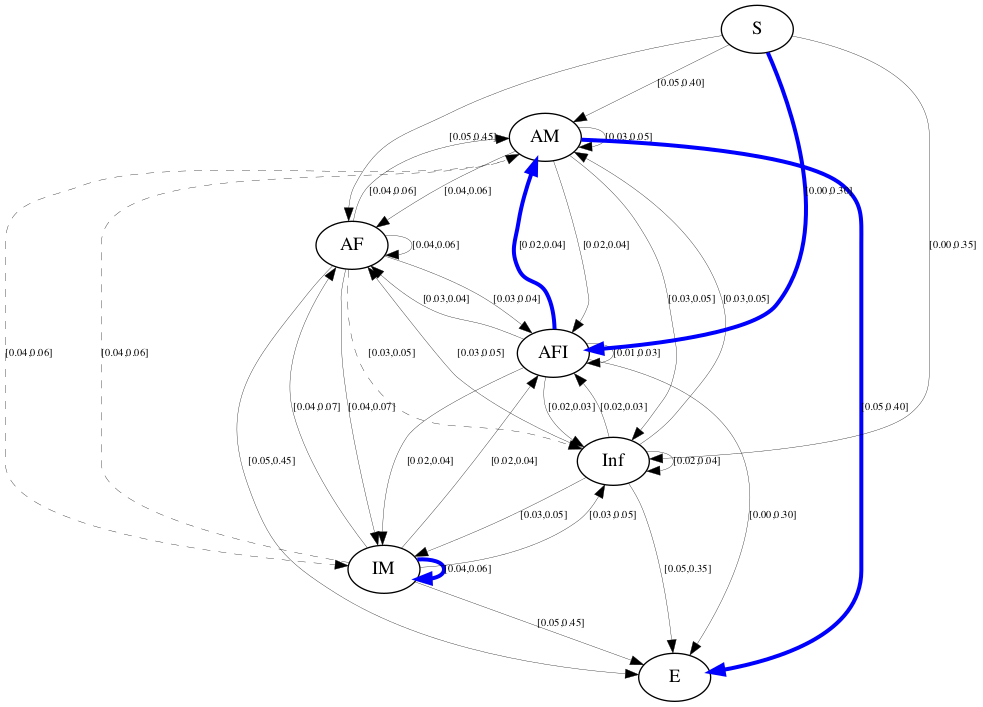

In [8]:
# init the transition counter
# note: make adjacency zero matrix here; row index corresponds to ["start", "blue", "red", "orange", "green", "yellow","end"]. 
# Accordingly, the index is set as, start: 0, blue: 1, red: 2, orange: 3, green: 4, yellow: 5, end: 6
transition_counter = np.zeros(shape = (7,7))
dict_color2index = {
    "start": 0, 
    "blue": 1, 
    "red": 2, 
    "orange": 3, 
    "green": 4, 
    "yellow": 5, 
    "end": 6,
    "grey": 7,
}

# mapping disctionary is set here.
age_sex_category_color_mapping_all = {
    "adultmalewo_infant": "blue",
    "adultmalewo_infantimmigrantmale": "blue",
    "adultfemalewo_infant": "red",
    "adultfemalewith_infant": "orange",
    "subadultmalewo_infant": "green",
    "subadultunidentifiedwo_infant": "green",
    "subadultfemalewo_infant":"green",
    "infantmalewo_infant": "yellow",
    "infantunidentifiedwo_infant":"yellow",
    "adultunidentifiedwo_infant": "grey",
    "unidentifiedunidentifiedwo_infant": "grey",
}

for i in df_cameratrap.unit.unique():
    caravan = list(df_cameratrap_all[df_cameratrap_all['unit'] == i].reset_index().age_sex_category.map(age_sex_category_color_mapping_all))
    # print(caravan)
    for j in range(1,len(caravan)):
        pre_monkey = dict_color2index[caravan[j-1]]
        post_monkey = dict_color2index[caravan[j]]
        
        if (pre_monkey == 7 or post_monkey == 7):
            pass
        else:
            transition_counter[pre_monkey,post_monkey] += 1 
        
    transition_counter[0,dict_color2index[caravan[0]]] += 1
    transition_counter[dict_color2index[caravan[-1]],-1] += 1

g = Digraph(format="png")

g.node("1", label="AM")
g.node("2", label="AF")
g.node("3", label="AFI")
g.node("4", label="IM")
g.node("5", label="Inf")
g.node("0",label="S")
g.node("6", label="E")


for i, j in list(itertools.product(range(7), range(7))):
    edge_style = "solid"
    color = "black"
    penwidth = "0.25"

    if i == 0 and j == 6:
        pass
    elif i == 6 or j == 0:
        pass
    elif transition_counter[i,j] == 0:
        pass
    elif i == 0 or j == 6:
        if transition_counter[i,j]/20 < np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 2.5)[i,j]:
            edge_style = "dashed"
            color = "darkgrey"
        elif transition_counter[i,j]/20 > np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 97.5)[i,j]:
            edge_style = "bold"
            color = "blue"
            penwidth = "3"
        g.edge(str(i), str(j), label = "[%1.2f,%1.2f]" %(np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 2.5)[i,j], np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 97.5)[i,j]), style = edge_style, color = color, penwidth = penwidth, fontsize = "8")
    else:
        if transition_counter[i,j]/np.sum(transition_counter[1:-1,1:-1]) < np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 2.5)[i,j]:
            edge_style = "dashed"
#             color = "darkgrey"
        elif transition_counter[i,j]/np.sum(transition_counter[1:-1,1:-1]) > np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 97.5)[i,j]:
            edge_style = "bold"
            color = "blue"
            penwidth = "3"
        g.edge(str(i), str(j), label = "[%1.2f,%1.2f]" %(np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 2.5)[i,j], np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 97.5)[i,j]), style = edge_style, color = color, penwidth = penwidth, fontsize = "8")

g.render("png/figure_2_transition_caravan_all_randambaseline_95percentile")

# show png in this jupyter notebook
from IPython.display import Image
Image('./png/figure_2_transition_caravan_all_randambaseline_95percentile.png')

### 2.5. Summary tables of probability and percentiles

In [9]:
dict_index2category = dict(
    {
        0:"Start",
        1: "AM",
        2: "AF",
        3: "AFI",
        4: "IM",
        5: "Inf",
        6: "E", 
    }
)

transition_prob = dict()

for i, j in list(itertools.product(range(7), range(7))):
    if i == 0 and j != 0 and j != 6:
        transition_prob.update(
            {
                "{0}2{1}".format(dict_index2category[i],dict_index2category[j]):{
                    "prob_observation": transition_counter[i,j]/20,
                    "2.5percentile": np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 2.5)[i,j],
                    "97.5percentile": np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 97.5)[i,j],
                    "significance": ["*" if (transition_counter[i,j]/20 < np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 2.5)[i,j] or transition_counter[i,j]/20 > np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 97.5)[i,j]) else "-"][0]
                },
            }
        )
    elif j == 6 and i != 0 and i != 6:
        transition_prob.update(
            {
                "{0}2{1}".format(dict_index2category[i],dict_index2category[j]):{
                    "prob_observation": transition_counter[i,j]/20,
                    "2.5percentile": np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 2.5)[i,j],
                    "97.5percentile": np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 97.5)[i,j],
                    "significance": ["*" if (transition_counter[i,j]/20 < np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 2.5)[i,j] or transition_counter[i,j]/20 > np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 97.5)[i,j]) else "-"][0]
                },
            }
        )
    elif i != 0 and j != 0 and i != 6:
        transition_prob.update(
            {
                "{0}2{1}".format(dict_index2category[i],dict_index2category[j]):{
                    "prob_observation": transition_counter[i,j]/np.sum(transition_counter[1:-1,1:-1]),
                    "2.5percentile": np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 2.5)[i,j],
                    "97.5percentile": np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 97.5)[i,j],
                    "significance": ["*" if (transition_counter[i,j]/np.sum(transition_counter[1:-1,1:-1]) < np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 2.5)[i,j] or transition_counter[i,j]/np.sum(transition_counter[1:-1,1:-1]) > np.percentile(transition_counter_probablity_random_baseline,axis=2, q = 97.5)[i,j]) else "-"][0]
                },
            }
        )
df_transition = pd.DataFrame(transition_prob).T
df_transition.to_csv("table/transition_probs_table1.csv",index_label="transitions")

## 3. Potiional ratio of the passing order for each sex/age category in the SFM.

### 3.1. Calculate the positional ratios for each subject with sex and age classes, then generate numpy arraies.

In [8]:
# passing sex age categories

adultmale_positional_ratio_s = np.zeros(shape = (1,1))
adultfemale_positional_ratio_s = np.zeros(shape = (1,1))
infantcarry_positional_ratio_s = np.zeros(shape = (1,1))
youngadult_positional_ratio_s = np.zeros(shape = (1,1))
infant_positional_ratio_s = np.zeros(shape = (1,1))

# define mapping 
age_sex_category_numerical_mapping = {
    "adultmalewo_infant": 0,
    "adultfemalewo_infant": 1,
    "adultfemalewith_infant": 2,
    "subadultmalewo_infant": 3,
    "subadultfemalewo_infant": 4,
    "infantmalewo_infant": 5,
    "unidentified": 9,
}
# mapping disctionary is set here.
age_sex_category_color_mapping_all = {
    "adultmalewo_infant": "blue",
    "adultmalewo_infantimmigrantmale": "blue",
    "adultfemalewo_infant": "red",
    "adultfemalewith_infant": "orange",
    "subadultmalewo_infant": "green",
    "subadultunidentifiedwo_infant": "green",
    "subadultfemalewo_infant":"green",
    "infantmalewo_infant": "yellow",
    "infantunidentifiedwo_infant":"yellow",
    "adultunidentifiedwo_infant": "grey",
    "unidentifiedunidentifiedwo_infant": "grey",
}

for n in range(1):
    for i in df_cameratrap.unit.unique():
        caravan = np.array(df_cameratrap_all[df_cameratrap_all['unit'] == i].reset_index().age_sex_category.map(age_sex_category_numerical_mapping))
        adultmale_positional_ratio = np.argwhere(caravan == 0).reshape(1,-1)/len(caravan)
        adultfemale_positional_ratio = np.argwhere(caravan == 1).reshape(1,-1)/len(caravan)
        infantcarry_positional_ratio = np.argwhere(caravan == 2).reshape(1,-1)/len(caravan)

        adultmale_positional_ratio_s = np.hstack([adultmale_positional_ratio_s, adultmale_positional_ratio])
        adultfemale_positional_ratio_s = np.hstack([adultfemale_positional_ratio_s, adultfemale_positional_ratio])
        infantcarry_positional_ratio_s = np.hstack([infantcarry_positional_ratio_s,infantcarry_positional_ratio])

### 3.2. Visualize the positional ratios for each category of sex and age class, social class(infant carrier or not).

The head and tail of the single-file line are set to 0 and 1, respectively, and the positional ratios were represented as values $\in [0,1]$

/Users/hirokikoda/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially

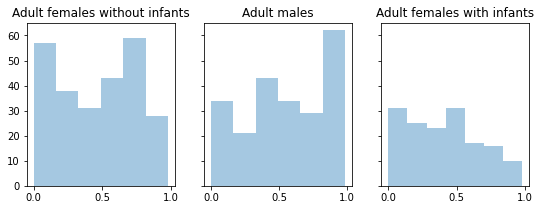

In [9]:
fig, ax = plt.subplots(1,3, figsize = (9,3), sharey = True)
sns.distplot(adultfemale_positional_ratio_s[0,1:], ax=ax[0], kde = False)
ax[0].set_title('Adult females without infants')
sns.distplot(adultmale_positional_ratio_s[0,1:], ax=ax[1], kde= False)
ax[1].set_title("Adult males")
sns.distplot(infantcarry_positional_ratio_s[0,1:], ax=ax[2], kde= False)
ax[2].set_title('Adult females with infants')
plt.savefig('png/figure_3_positional_ratio.png', dpi = 300)
plt.savefig('eps/figure_3_positional_ratio.eps')

### 3.3. Kruskal-Walis test for the data in above section 3.2.

In [10]:
from scipy import stats
kruskal_result_all = stats.kruskal(adultfemale_positional_ratio_s.T[:,0],adultmale_positional_ratio_s.T[:,0],infantcarry_positional_ratio_s.T[:,0])
kruskal_AF_AM = stats.kruskal(adultfemale_positional_ratio_s.T[:,0],adultmale_positional_ratio_s.T[:,0])
kruskal_AF_IC = stats.kruskal(adultfemale_positional_ratio_s.T[:,0],infantcarry_positional_ratio_s.T[:,0])
kruskal_AM_IC = stats.kruskal(adultmale_positional_ratio_s.T[:,0],infantcarry_positional_ratio_s.T[:,0])

print(
    "all: %s \nAF-AM: %s\nAF-AFI: %s\nAM-AFI: %s" % (kruskal_result_all, kruskal_AF_AM, kruskal_AF_IC, kruskal_AM_IC)
)

all: KruskalResult(statistic=23.01739048662549, pvalue=1.0042391816749496e-05) 
AF-AM: KruskalResult(statistic=11.468299341614895, pvalue=0.0007079343470580732)
AF-AFI: KruskalResult(statistic=3.1095448634155733, pvalue=0.0778347079281149)
AM-AFI: KruskalResult(statistic=20.666742360081063, pvalue=5.465715291854495e-06)


## 4. Codes for supplementary processes
The codes below are used for the supplementary analysis, of which results and figures were not mentioned in the manuscript main text or elsewhere. I just ran the codes below for checking the visualizations of the lines when I analyzed only adult data without considering unidentifiable subjects or infants. The motivation of these visualization of the single-file movement data was to "match" the result reports with another results of the social network analysis (SNA). In the SNA, I illustrated the network based only on identified monkey data.

### 4.1. Visualize and transition diagram of the all identified adult subjects, excluding the unidentified subjects such as infant or young adults (4-6 yrs old)
Figure generation (as supplementary figure)

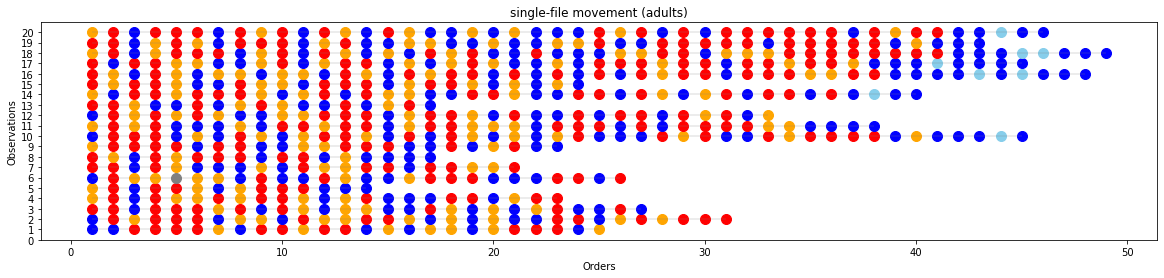

In [10]:
# visualize the single-file movements focusing only on adults (eliminating youngadult, infant or unidentified subjects)
df_cameratrap["age_sex_category"] = df_cameratrap["age"] + df_cameratrap["sex"]
df_cameratrap.age_sex_category = df_cameratrap.age_sex_category.fillna('unidentified')

infant_carry_status_mapping = {v:"with_infant" for v in mother_female_list}
immigrant_male_status_mapping = {v: "immigrantmale" for v in ["tsukamoto", "morikami", "kuroda", "higuchi", "nakahara"]}

df_cameratrap["infant_carry_status"] = df_cameratrap.name.map(infant_carry_status_mapping).fillna('wo_infant')
df_cameratrap["immigrant_male_status"] = df_cameratrap.name.map(immigrant_male_status_mapping).fillna('')
df_cameratrap["age_sex_category"] = df_cameratrap["age"] + df_cameratrap["sex"] + df_cameratrap["infant_carry_status"] + df_cameratrap["immigrant_male_status"]
df_cameratrap.age_sex_category = df_cameratrap.age_sex_category.fillna('unidentified')

age_sex_category_color_mapping = {
    "adultmalewo_infant": "blue",
    "adultmalewo_infantimmigrantmale": "skyblue",
    "adultfemalewo_infant": "red",
    "adultfemalewith_infant": "orange",
    "subadultmalewo_infant": "skyblue",
    "subadultfemalewo_infant": "pink",
    "infantmalewo_infant": "yellow",
    "unidentified": "grey"
}

fig, ax = plt.subplots(1,1, figsize = (20,4))

for unit_id in df_cameratrap['unit'].unique():
    caravan_agesex = df_cameratrap[df_cameratrap['unit'] == unit_id].reset_index().age_sex_category.map(age_sex_category_color_mapping)
    # caravan = df_cameratrap[df_cameratrap['unit'] == unit_id].reset_index().name
    plt.hlines(y = unit_id,xmin = 1, xmax = len(caravan_agesex), colors= "grey", linewidth = 0.3)
    for j, sub in enumerate(caravan_agesex):
        col = sub
        ax.scatter(j+1,unit_id, color = col, s=100)
            
ax.set_yticks(range(21))
plt.title('single-file movement (adults)')
plt.xlabel('Orders')
plt.ylabel('Observations')
# plt.show()
plt.savefig('supple/figure_s1_single_file_movements_only_adult.png', dpi = 300)
plt.savefig('supple/figure_s1_single_file_movements_only_adult.eps')

### 4.2. Generate transition diagram of the single-file movements focusing only on adults (eliminating young adult, infant or unidentified subjects)
This is based on the 5 states classifications, simpler classifications than 7 states used in the main text of the manusciript.

In [11]:
# count the transition 
m2f = 0
f2m = 0
c2m = 0
m2c = 0
c2f = 0
f2c = 0
m2m = 0
f2f = 0
c2c = 0
s2m = 0
s2f = 0
s2c = 0
m2e = 0
f2e = 0
c2e = 0

# define mapping 
age_sex_category_color_mapping = {
    "adultmalewo_infant": "blue",
    "adultfemalewo_infant": "red",
    "adultfemalewith_infant": "orange",
    "subadultmalewo_infant": "skyblue",
    "subadultfemalewo_infant": "pink",
    "infantmalewo_infant": "yellow",
    "unidentified": "grey"
}

for i in df_cameratrap.unit.unique():
    caravan = list(df_cameratrap[df_cameratrap['unit'] == i].reset_index().age_sex_category.map(age_sex_category_color_mapping))
    # print(caravan)
    for j in range(1,len(caravan)):
        twomonkey = caravan[j-1:j+1]
        # print(twomonkey)
        if twomonkey == ['blue', 'red']:
            m2f +=1
        elif twomonkey == ['blue', 'orange']:
            m2c +=1
        elif twomonkey == ['blue', 'blue']:
            m2m +=1
        elif twomonkey == ['red', 'blue']:
            f2m +=1
        elif twomonkey == ['red', 'orange']:
            f2c +=1
        elif twomonkey == ['red', 'red']:
            f2f += 1
        elif twomonkey == ['orange', 'blue']:
            c2m += 1
        elif twomonkey == ['orange', 'red']:
            c2f += 1
        elif twomonkey == ['orange', 'orange']:
            c2c += 1
        else:
            pass
    
    if caravan[0] == 'blue':
        s2m += 1
    elif caravan[0] == 'red':
        s2f += 1
    elif caravan[0] == 'orange':
        s2c += 1
    if caravan[-1] == 'blue':
        m2e += 1
    elif caravan[-1] == 'red':
        f2e += 1
    elif caravan[-1] == 'orange':
        c2e += 1

total_observation_start_trans = s2m + s2f + s2c
total_observation_inter_trans = m2m + m2f + m2c + f2m + f2f + f2c + c2m + c2f + c2c
total_last_trans = m2e + f2e + c2e

g = Digraph(format="png")

g.node("1", label="AM")
g.node("2", label="AF")
g.node("3", label="AFI")
g.node("0",label="S")
g.node("4", label="E")

g.edge("0","1", label="%1.4f" % (s2m/total_observation_start_trans))
g.edge("0","2", label="%1.4f" % (s2f/total_observation_start_trans))
g.edge("0","3", label="%1.4f" % (s2c/total_observation_start_trans))
g.edge("1","2", label="%1.4f" % (m2f/total_observation_inter_trans), style = "dashed", color = "grey")
g.edge("2","1", label="%1.4f" % (f2m/total_observation_inter_trans), style = "dashed", color = "grey")
g.edge("1","3", label="%1.4f" % (m2c/total_observation_inter_trans))
g.edge("3","1", label="%1.4f" % (c2m/total_observation_inter_trans))
g.edge("2","3", label="%1.4f" % (f2c/total_observation_inter_trans))
g.edge("3","2", label="%1.4f" % (c2f/total_observation_inter_trans))
g.edge("1","4", label="%1.4f" % (m2e/total_last_trans), style = "bold", color = "blue")
g.edge("2","4", label="%1.4f" % (f2e/total_last_trans))
g.edge("3","4", label="%1.4f" % (c2e/total_last_trans))
g.edge("1","1", label="%1.4f" % (m2m/total_observation_inter_trans))
g.edge("2","2", label="%1.4f" % (f2f/total_observation_inter_trans), style = "bold", color = "blue")
g.edge("3","3", label="%1.4f" % (c2c/total_observation_inter_trans))

g.render("supple/figure_s2_transition_caravan_5_states_classifications")

'supple/figure_s2_transition_caravan_5_states_classifications.png'

### 4.3. Baseline permutation matching with the only-adult data.


In [12]:
# count the transition 
m2f_s = []
f2m_s = []
c2m_s = []
m2c_s = []
c2f_s = []
f2c_s = []
m2m_s = []
f2f_s = []
c2c_s = []
s2m_s = []
s2f_s = []
s2c_s = []
m2e_s = []
f2e_s = []
c2e_s = []

# define mapping 
age_sex_category_color_mapping = {
    "adultmalewo_infant": "blue",
    "adultfemalewo_infant": "red",
    "adultfemalewith_infant": "orange",
    "subadultmalewo_infant": "skyblue",
    "subadultfemalewo_infant": "pink",
    "infantmalewo_infant": "yellow",
    "unidentified": "grey"
}

for n in range(10000):
    m2f = 0
    f2m = 0
    c2m = 0
    m2c = 0
    c2f = 0
    f2c = 0
    m2m = 0
    f2f = 0
    c2c = 0
    s2m = 0
    s2f = 0
    s2c = 0
    m2e = 0
    f2e = 0
    c2e = 0
    for i in df_cameratrap.unit.unique():
        caravan = list(df_cameratrap[df_cameratrap['unit'] == i].reset_index().age_sex_category.map(age_sex_category_color_mapping))
        # print(caravan)
        random.shuffle(caravan)
        for j in range(1,len(caravan)):
            twomonkey = caravan[j-1:j+1]
            # print(twomonkey)
            if twomonkey == ['blue', 'red']:
                m2f +=1
            elif twomonkey == ['blue', 'orange']:
                m2c +=1
            elif twomonkey == ['blue', 'blue']:
                m2m +=1
            elif twomonkey == ['red', 'blue']:
                f2m +=1
            elif twomonkey == ['red', 'orange']:
                f2c +=1
            elif twomonkey == ['red', 'red']:
                f2f += 1
            elif twomonkey == ['orange', 'blue']:
                c2m += 1
            elif twomonkey == ['orange', 'red']:
                c2f += 1
            elif twomonkey == ['orange', 'orange']:
                c2c += 1
            else:
                pass
        
        if caravan[0] == 'blue':
            s2m += 1
        elif caravan[0] == 'red':
            s2f += 1
        elif caravan[0] == 'orange':
            s2c += 1

        if caravan[-1] == 'blue':
            m2e += 1
        elif caravan[-1] == 'red':
            f2e += 1
        elif caravan[-1] == 'orange':
            c2e += 1
# print(s2m)
    total_observation_start_trans = s2m + s2f + s2c
    total_observation_inter_trans = m2m + m2f + m2c + f2m + f2f + f2c + c2m + c2f + c2c
    total_last_trans = m2e + f2e + c2e
    s2m_s.append(s2m/total_observation_start_trans)
    s2f_s.append(s2f/total_observation_start_trans)
    s2c_s.append(s2c/total_observation_start_trans)
    m2f_s.append(m2f/total_observation_inter_trans)
    f2m_s.append(f2m/total_observation_inter_trans)
    m2c_s.append(m2c/total_observation_inter_trans)
    c2m_s.append(c2m/total_observation_inter_trans)
    f2c_s.append(f2c/total_observation_inter_trans)
    c2f_s.append(c2f/total_observation_inter_trans)
    m2e_s.append(m2e/total_last_trans)
    f2e_s.append(f2e/total_last_trans)
    c2e_s.append(c2e/total_last_trans)
    m2m_s.append(m2m/total_observation_inter_trans)
    f2f_s.append(f2f/total_observation_inter_trans)
    c2c_s.append(c2c/total_observation_inter_trans)

m2m_percentile = [np.percentile(m2m_s,2.5),np.percentile(m2m_s,97.5)]
m2f_percentile = [np.percentile(m2f_s,2.5),np.percentile(m2f_s,97.5)]
m2c_percentile = [np.percentile(m2c_s,2.5),np.percentile(m2c_s,97.5)]
f2m_percentile = [np.percentile(f2m_s,2.5),np.percentile(f2m_s,97.5)]
f2f_percentile = [np.percentile(f2f_s,2.5),np.percentile(f2f_s,97.5)]
f2c_percentile = [np.percentile(f2c_s,2.5),np.percentile(f2c_s,97.5)]
c2m_percentile = [np.percentile(c2m_s,2.5),np.percentile(c2m_s,97.5)]
c2f_percentile = [np.percentile(c2f_s,2.5),np.percentile(c2f_s,97.5)]
c2c_percentile = [np.percentile(c2c_s,2.5),np.percentile(c2c_s,97.5)]
s2m_percentile = [np.percentile(s2m_s,2.5),np.percentile(s2m_s,97.5)]
s2f_percentile = [np.percentile(s2f_s,2.5),np.percentile(s2f_s,97.5)]
s2c_percentile = [np.percentile(s2c_s,2.5),np.percentile(s2c_s,97.5)]
m2e_percentile = [np.percentile(m2e_s,2.5),np.percentile(m2e_s,97.5)]
f2e_percentile = [np.percentile(f2e_s,2.5),np.percentile(f2e_s,97.5)]
c2e_percentile = [np.percentile(c2e_s,2.5),np.percentile(c2e_s,97.5)]

g = Digraph(format="png")

g.node("1", label="AM")
g.node("2", label="AF")
g.node("3", label="AFI")
g.node("0",label="S")
g.node("4", label="E")

fontsize = "10"
g.edge("0","1", label="[%1.2f,%1.2f]" % (s2m_percentile[0], s2m_percentile[1]), fontsize = fontsize)
g.edge("0","2", label="[%1.2f,%1.2f]" % (s2f_percentile[0], s2f_percentile[1]), fontsize = fontsize)
g.edge("0","3", label="[%1.2f,%1.2f]" % (s2c_percentile[0], s2c_percentile[1]), fontsize = fontsize)
g.edge("1","2", label="[%1.2f,%1.2f]" % (m2f_percentile[0], m2f_percentile[1]), fontsize = fontsize)
g.edge("2","1", label="[%1.2f,%1.2f]" % (f2m_percentile[0], f2m_percentile[1]), fontsize = fontsize)
g.edge("1","3", label="[%1.2f,%1.2f]" % (m2c_percentile[0], m2c_percentile[1]), fontsize = fontsize)
g.edge("3","1", label="[%1.2f,%1.2f]" % (c2m_percentile[0], c2m_percentile[1]), fontsize = fontsize)
g.edge("2","3", label="[%1.2f,%1.2f]" % (f2c_percentile[0], f2c_percentile[1]), fontsize = fontsize)
g.edge("3","2", label="[%1.2f,%1.2f]" % (c2f_percentile[0], c2f_percentile[1]), fontsize = fontsize)
g.edge("1","4", label="[%1.2f,%1.2f]" % (m2e_percentile[0], m2e_percentile[1]), fontsize = fontsize)
g.edge("2","4", label="[%1.2f,%1.2f]" % (f2e_percentile[0], f2e_percentile[1]), fontsize = fontsize)
g.edge("3","4", label="[%1.2f,%1.2f]" % (c2e_percentile[0], c2e_percentile[1]), fontsize = fontsize)
g.edge("1","1", label="[%1.2f,%1.2f]" % (m2m_percentile[0], m2m_percentile[1]), fontsize = fontsize)
g.edge("2","2", label="[%1.2f,%1.2f]" % (f2f_percentile[0], f2f_percentile[1]), fontsize = fontsize)
g.edge("3","3", label="[%1.2f,%1.2f]" % (c2c_percentile[0], c2c_percentile[1]), fontsize = fontsize)

g.render("supple/figure_s3_transition_caravan_shuffle")

'supple/figure_s3_transition_caravan_shuffle.png'